# Natural Language Processing: Disaster Tweets

# Introduction <br>
The aim of this notebook is to be able to classify tweets into two categories, tweets that are about actual disasters and tweets that are not about disasters. This will be done using NLP and machine learning, on a dataset of 10,000 tweets. 

**DISCLAIMER: SOME TWEETS MAY CONTAIN EXPLICIT LANGUAGE**

**What is NLP?**<br>

NLP stands for Natural Language Processing, this is defined by the Oxford Languages Dictionary as 'The application of computational techniques to the analysis and synthesis of natural language and speech'. Natural language is the way humans talk to each other through things such as text and speech.<br>

Language can be incredibly difficult, it is a thing that takes each one of us years to learn and even then we often make mistakes throughout our lives. NLP as a tool is very powerful but it faces many limitations and problems; such as the ability to understand context, sarcasm, errors in the text, slang, and ambiguity. This can have an impact on how our models may decide the outcome of the tweet so we can already predict that it will make some mistakes when trying to predict the outcome. 

## Let's get started! 

The first steps like in every project are to import our libraries and then read in our data. 

In [101]:
# Import Libraries 
import io 
import re
import string 
import unicodedata
import spacy 
import matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SpatialDropout1D
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
from spellchecker import SpellChecker
from wordcloud import WordCloud
from IPython.display import display

Now we need to read in our dataset and store it in a dataframe so we can easily access and manipulate it. 

In [2]:
# Read in Data
tweets = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Let's take a look at what the data looks like 
tweets.head(10)
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [4]:
print(f'Rows: {tweets.shape[0]}, Columns: {tweets.shape[1]} in the training data.')
print(f'Rows: {test.shape[0]}, Columns: {test.shape[1]} in the test data.')

Rows: 7613, Columns: 5 in the training data.
Rows: 3263, Columns: 4 in the test data.


So we can see that the test data is missing the target column, but our training data includes this. So the end result is to predict the target column for the test data. 

<AxesSubplot:>

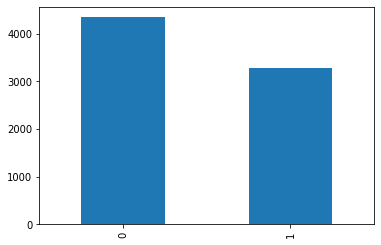

In [5]:
# Lets see what the target looks like 
tweets.describe()
tweets.target.value_counts().plot(kind = 'bar')

There are more tweets with no mention of disaster than tweets with a disaster. This is known as a class imbalance, machine learning models work best when the outcome classes are about equal. It isn't a huge difference so maybe we can play about with reducing this imbalance later if we don't get the results we are hoping for. We will consider a range of measures when trying to determine the performance of the models as accuracy can be flawed when there is a class imbalance. 

In [6]:
#Look at an example tweet
tweets['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

# Data Cleaning 

The next step should be to clean the data and make it as usable as possible. I will first make a copy of the data just to be on the safe side.

In [7]:
# Combine both test and train data into a new df for cleaning 
df = pd.concat([tweets, test])
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


Hashtags are a common feature of many tweets and are often used inline, so the symbols should be stripped along with any other special characters. 

In [8]:
# Create a test string to check the data cleaning process
test = "[This is just to test] somerandom@text.totest, https://maybe.the/tweet/contains.alink<br>😔, I am a #bad #person corevt the word?"

In [16]:
# Remove any links 
def remove_hyperlink(data):
    isurl = re.compile(r'https?://\S+|www.\.\S+')
    return isurl.sub(r'', data)

# Remove any special characters
def remove_special_chars(data):
    data = re.sub('[,\.!:;()"]', ' ', data)
    data = re.sub('[^a-zA-Z"]', ' ', data)
    data = re.sub('\[[^]]*\]', ' ', data)
    return data

# Make Lower Case
def make_lower(data):
    data = data.str.lower()
    return data

# Remove any HTML
def remove_html(data):
    soup = BeautifulSoup(data, 'html.parser')
    return soup.get_text()

# Remove any Emojis
def remove_emojis(data):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return emojis.sub(r'',data)

# Remove double spaces
def remove_doublespaces(data):
    data = re.sub('  ', ' ', data)
    data = re.sub('  ', ' ', data)
    return data

# Correct Mispellings 
spell = SpellChecker()
def correct_spelling(data):
    corrected = []
    mispellings = spell.unknown(data.split())
    for word in data.split():
        if word in mispellings:
            corrected.append(spell.correction(word))
        else:
            corrected.append(word)
    return " ".join(corrected)


stopw = set(stopwords.words('english'))
# Tokenize and remove stopwords 
def filter_on_stopwords(data):
    word_tokens = word_tokenize(data)
    no_stopword_tokens = [token for token in word_tokens if token not in stopw]
    data = ' '.join(no_stopword_tokens)
    return data

sp = spacy.load('en_core_web_sm')
def lemmatize_words(data):
    doc = sp(data)   
    data = ' '.join([token.lemma_ for token in doc])
    return data

In [10]:
'''# Call these functions 
test = remove_hyperlink(test)
test = remove_special_chars(test)
test = make_lower(test)
test = remove_html(test)
test = remove_emojis(test)
test = remove_doublespaces(test)
test = correct_spelling(test)
test'''

'# Call these functions \ntest = remove_hyperlink(test)\ntest = remove_special_chars(test)\ntest = make_lower(test)\ntest = remove_html(test)\ntest = remove_emojis(test)\ntest = remove_doublespaces(test)\ntest = correct_spelling(test)\ntest'

In [11]:
# Now we know that the data cleanining functions work as expected we can apply them to our combibned data
df['text'] = df['text'].apply(remove_hyperlink)
df['text'] = df['text'].apply(remove_special_chars)
df['text'] = make_lower(df['text'])
df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(remove_emojis)
df['text'] = df['text'].apply(remove_doublespaces)
df['text'] = df['text'].apply(correct_spelling)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0
1,4,NaN,NaN,forest fire near la range ask canada,1.0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0


In [17]:
# Remove stopwords and lemmatize the words
df['text'] = df['text'].apply(filter_on_stopwords)
df['text'] = df['text'].apply(lemmatize_words)

In [14]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la range ask canada,1.0
2,5,NaN,NaN,residents asked shelter place notified officer...,1.0
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1.0
5,8,NaN,NaN,rockyfire update california closed directions ...,1.0
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1.0
7,13,NaN,NaN,top hill see fire woods,1.0
8,14,NaN,NaN,emergency evacuation happening building across...,1.0
9,15,NaN,NaN,afraid tornado coming area,1.0


## Data Exploration

Now that our data has been cleaned and the stopwords have been removed, we can do a deeper exploration of the data to see what it looks like. 

Text(0.5, 1.0, 'Most Common Words in Tweets about Disaster')

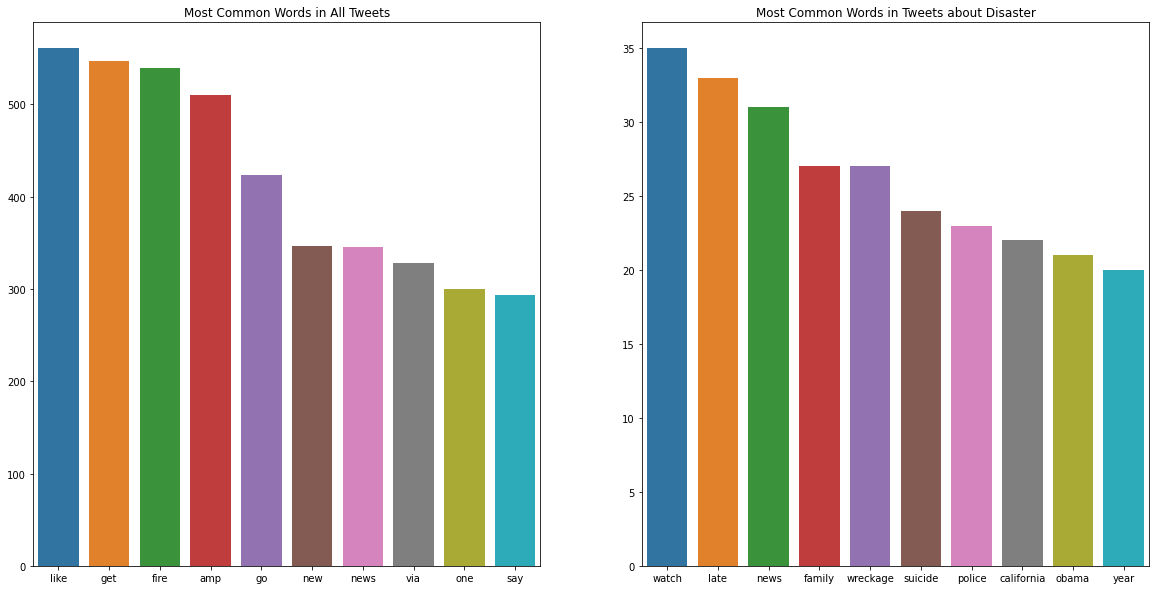

In [68]:
# Get the frequency distribution of the most popular words
words = [word for word in pd.Series(' '.join(df['text']).split())]
most_used_words = FreqDist(words).most_common(10)
most_used_words = pd.Series(dict(most_used_words))
#Plot the most commonly used words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.barplot(x = most_used_words.index, y = most_used_words.values, ax=ax1)

#Get the frequency distribution where tweets are about disaster
disaster_tweets = df[df['target']==1]['text']
disaster_words = [word.split()[0] for word in disaster_tweets]
most_used_disaster_words = FreqDist(disaster_words).most_common(10)
most_used_disaster_words = pd.Series(dict(most_used_disaster_words))
sns.barplot(x = most_used_disaster_words.index, y = most_used_disaster_words.values, ax=ax2)
ax1.set_title('Most Common Words in All Tweets')
ax2.set_title('Most Common Words in Tweets about Disaster')

In [36]:
# Number of unique words
unique_words = []
for word in words:
    if not word in unique_words:
        unique_words.append(word)

print(f'Number of Uniques Words: {len(unique_words)}')

Number of Uniques Words: 15404


Text(0.5, 1.0, 'Tweets that are not about Disaster')

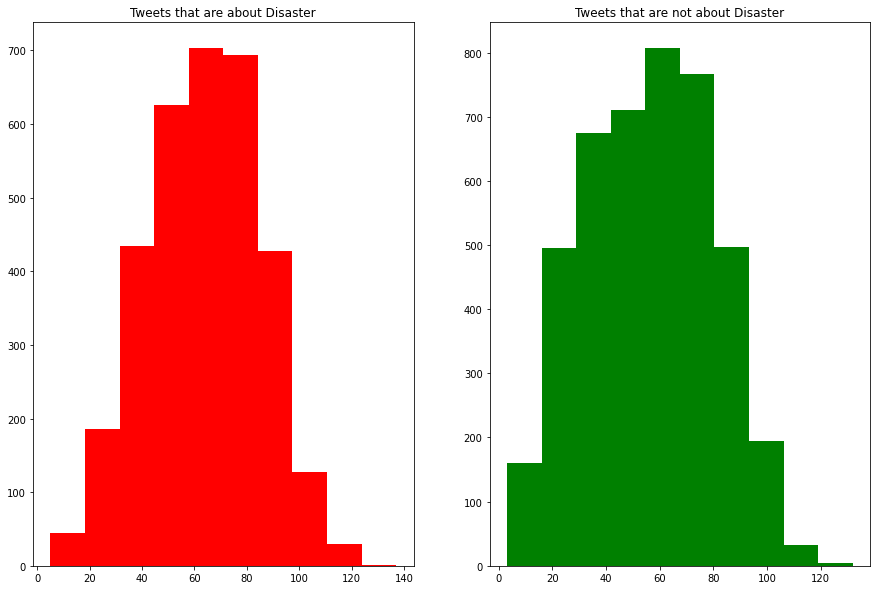

In [42]:
# Number of words in a tweet 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
# Get len of disaster tweets
tweet_length = df[df['target']==1]['text'].str.len()
ax1.hist(tweet_length, color = 'red')
ax1.set_title('Tweets that are about Disaster')
# Get len of tweets that are not about disaster
tweet_length = df[df['target']==0]['text'].str.len()
ax2.hist(tweet_length, color = 'green')
ax2.set_title('Tweets that are not about Disaster')

There doesn't seem to be a real difference in the length of tweets between the two target classes. 

Let's see how the wordclouds will look 

(-0.5, 399.5, 199.5, -0.5)

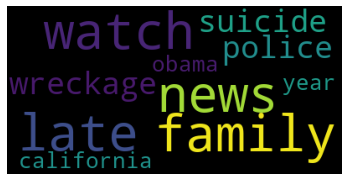

In [83]:
most_used_disaster_words_index = most_used_disaster_words.index
disaster_wordcloud = WordCloud(background_color = 'black', max_font_size = 60).generate(" ".join(most_used_disaster_words_index))
plt.imshow(disaster_wordcloud)
plt.axis('off')

I have never tried a bag of words before or LSA, so let's try it out. 
Code from: https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

In [104]:
# Bag of Words
def _count_vectorizer(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df['text'].tolist()
list_labels = df['target'].tolist()

x_train, x_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size = 0.3, random_state = 0)

x_train_counts, count_vectorizer = _count_vectorizer(x_train)
x_test_counts = count_vectorizer.transform(x_test)

<function matplotlib.pyplot.show(close=None, block=None)>

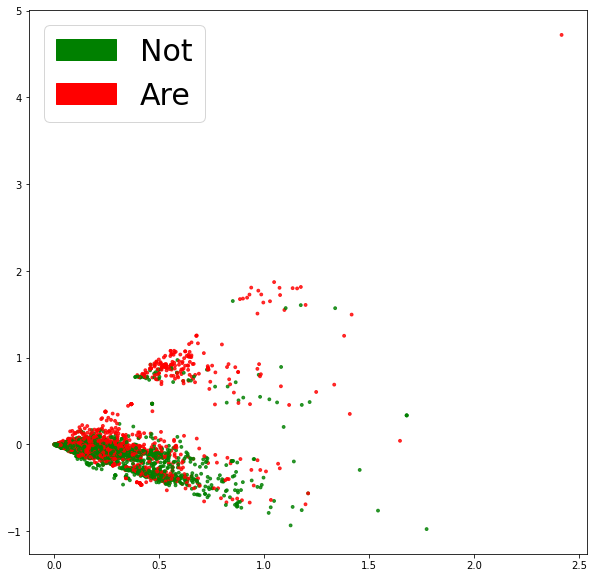

In [112]:
def plot_LSA(data, labels, savepath ='PCA.csv', plot = True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(data)

    lsa_scores = lsa.transform(data)

    color_mapper = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['green','red']

    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s = 8, alpha = .8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        green_patch = matplotlib.patches.Patch(color = 'green', label = 'Not')
        red_patch = matplotlib.patches.Patch(color = 'red', label = 'Are')
        plt.legend(handles = [green_patch, red_patch], prop = {'size':30})

fig = plt.figure(figsize=(10,10))
plot_LSA(x_train_counts, y_train)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

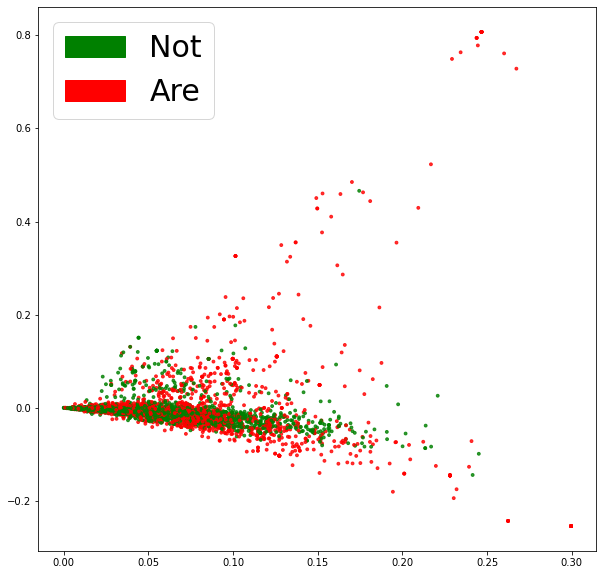

In [111]:
# See how TF IDF looks
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    t = tfidf_vectorizer.fit_transform(data)
    return t, tfidf_vectorizer

x_train_tfidf, tfidf_vectorizer = tfidf(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

fig = plt.figure(figsize=(10, 10))
plot_LSA(x_train_tfidf, y_train)
plt.show